# Tarea 1: Red neuronal densa
## De Jesús Pineda Agustín

En esta tarea se busca hacer una red neuronal con 3 capas densas para que con base en los datos médicos de un paciente se pueda predecir la probabilidad de sufrir un ataque cardiaco.

In [ ]:
#Importamos las librerias que vamos a necesitar en todo el proceso.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt


## Preparacion de los datos

In [ ]:
#Vamos a importar los datos y a visualizarlos
#df = pd.read_csv('/content/ataques_cardiacos.csv') #colab
df = pd.read_csv('ataques_cardiacos.csv') #local
print(df.head())
print('Dimensión:',df.shape)
print('nombres: ',df.columns)

   edad  anaemia  creatinina_fosfoquinasa  diabetes  fracción_de_eyeccion  \
0  75.0        0                      582         0                    20   
1  55.0        0                     7861         0                    38   
2  65.0        0                      146         0                    20   
3  50.0        1                      111         0                    20   
4  65.0        1                      160         1                    20   

   presion_alta  suero_de_creatinina  serum_sodium  sexo  fumador  \
0             1                  1.9           130     1        0   
1             0                  1.1           136     1        0   
2             0                  1.3           129     1        1   
3             0                  1.9           137     1        0   
4             0                  2.7           116     0        0   

   evento_de_muerte  
0                 1  
1                 1  
2                 1  
3                 1  
4           

Como vemos arriba tenemos una tabla con 299 renglones y 11 columnas, en donde la última columna 'evento de muerte' es la que indica de forma binaria si el motivo de la muerte due por un ataque cardiaco (1=si, 0=no), es decir, la última columna van a ser las etiquetas de nuestros datos.

In [ ]:
#Tensorflow trabaja con arreglos de numpy entonces hay que convertir los datos a este tipo de variable
df = np.array(df)
print(df)
print('dimensión:',df.shape)

[[7.500e+01 0.000e+00 5.820e+02 ... 1.000e+00 0.000e+00 1.000e+00]
 [5.500e+01 0.000e+00 7.861e+03 ... 1.000e+00 0.000e+00 1.000e+00]
 [6.500e+01 0.000e+00 1.460e+02 ... 1.000e+00 1.000e+00 1.000e+00]
 ...
 [4.500e+01 0.000e+00 2.060e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [4.500e+01 0.000e+00 2.413e+03 ... 1.000e+00 1.000e+00 0.000e+00]
 [5.000e+01 0.000e+00 1.960e+02 ... 1.000e+00 1.000e+00 0.000e+00]]
dimensión: (299, 11)


In [ ]:
#Separamos la tabla de datos en los datos de entrenamiento y validación junto con sus respectivas etiquetas
etiquetas = np.transpose(df)[10]#La última columna son las etiquetas
datos = np.delete(df,10,axis=1) #Quitamos la columna de etiquetas a los datos completos

datos_entrenamiento = datos[:220] #220 datos para entrenamiento
datos_prueba = datos[220:299] #79 datos para prueba

etiquetas_entrenamiento = etiquetas[:220]
etiquetas_prueba = etiquetas[220:]

In [ ]:
# Normalizamos los datos con respecto al promedio
# Es decir que contrario a la normaliación usual, los vamos a centrar en 0 y alejadosde este deacuerdo a su desviación estándar
# (puede haber valores mayores que 1 y menores que -1)
promedio = datos_entrenamiento.mean(axis=0)
datos_entrenamiento -= promedio
std = datos_entrenamiento.std(axis=0)
datos_entrenamiento /= std

#A los datos de prueba los normalizamos respecto al promedio de los datos de entrenamiento
datos_prueba -= promedio
datos_prueba /= std

## Arquitectura de la red neuronal

Se hicieron varias pruebas en cuanto al número de neuronas en las capas densas, con dopout y con regularizadores, al final se tienen 3 propuestas de modelos, todas funcionan con la función de activación 'relu' para las 2 primeras capas densas y 'sigmoid' para la última por que es un problema de clasificación binaria.

Tambíen comparten las 3 propuestas de modelos que el optimizador es 'rmsprop', la función de pérdida es 'binary_crossentropy' y la métrica es 'accuracy'.

In [ ]:
#Modelo 1:

model_1 = keras.Sequential([
    layers.Dense(32, activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model_1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_1 = model_1.fit(datos_entrenamiento,
                    etiquetas_entrenamiento,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.33,
                    shuffle =True,
                    verbose=0,
                    )
#Al final obtenemos la evaluación del modelo con respecto a los datos de prueba:
eval_dict_1 = model_1.evaluate(datos_prueba, etiquetas_prueba, return_dict = True)

3/3 [==============================] - 0s 3ms/step - loss: 0.5570 - accuracy: 0.7975


In [ ]:
#Modelo 2

model_2 = keras.Sequential([
    layers.Dense(64,
                 kernel_regularizer=tf.keras.regularizers.L1(0.02),
                 activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model_2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_2 = model_2.fit(datos_entrenamiento,
                    etiquetas_entrenamiento,
                    epochs=200,
                    batch_size=16,
                    validation_split=0.33,
                    shuffle =True,
                    verbose=0,
                    )

#Al final obtenemos la evaluación del modelo con respecto a los datos de prueba:
eval_dict = model_2.evaluate(datos_prueba, etiquetas_prueba, return_dict = True)

3/3 [==============================] - 0s 4ms/step - loss: 0.6472 - accuracy: 0.8228


In [ ]:
#Modelo 3

model_3 = keras.Sequential([
    layers.Dense(64,
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1 = 0.01, l2= 0.02),
                 activation = "relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

model_3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_3 = model_3.fit(datos_entrenamiento,
                    etiquetas_entrenamiento,
                    epochs=200,
                    batch_size=16,
                    validation_split=0.33,
                    shuffle =True,
                    verbose=0,
                    )

#Al final obtenemos la evaluación del modelo con respecto a los datos de prueba:
eval_dict = model_3.evaluate(datos_prueba, etiquetas_prueba, return_dict = True)

3/3 [==============================] - 0s 3ms/step - loss: 0.7928 - accuracy: 0.7722


## Resultados

## Gráficos

In [ ]:
#La instrución model.fit devuelve una variable tipo history que podemos revisar
#para acceder al historico se usa el atributo .history que devuelve un diccionario
#Hacemos un diccionario por cada modelo.
history_dict_1 = history_1.history
history_dict_2 = history_2.history
history_dict_3 = history_3.history

### Modelo 1

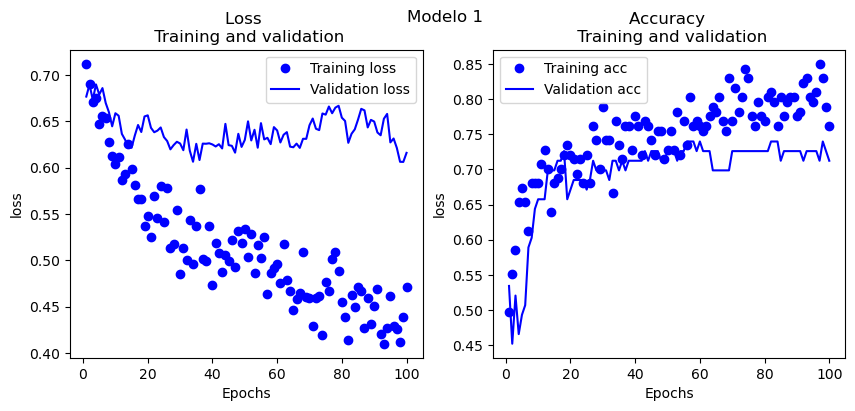

val_loss_min:  0.606  Epoch:  98


In [ ]:
#Graficando los valores de pérdida y accuracy para el entrenamiento y la validación
# Modelo 1

loss_values_1 = history_dict_1["loss"]
val_loss_values_1 = history_dict_1["val_loss"]
acc_1= history_dict_1["accuracy"]
val_acc_1 = history_dict_1["val_accuracy"]

epochs_1 = range(1, len(loss_values_1) + 1)
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(10,4))
fig.suptitle('Modelo 1')

ax1.plot(epochs_1, loss_values_1, "bo", label="Training loss")
ax1.plot(epochs_1, val_loss_values_1, "b", label="Validation loss")
ax1.set_title("Loss \n Training and validation")
ax1.set(xlabel="Epochs",ylabel='loss')

ax2.plot(epochs_1, acc_1, "bo", label="Training acc")
ax2.plot(epochs_1, val_acc_1, "b", label="Validation acc")
ax2.set_title("Accuracy \n Training and validation")
ax2.set(xlabel="Epochs",ylabel='loss')

ax1.legend()
ax2.legend()
plt.show()


print('val_loss_min: ',round(min(val_loss_values_1),3), ' Epoch: ',val_loss_values_1.index(min(val_loss_values_1)))

### Modelo 2

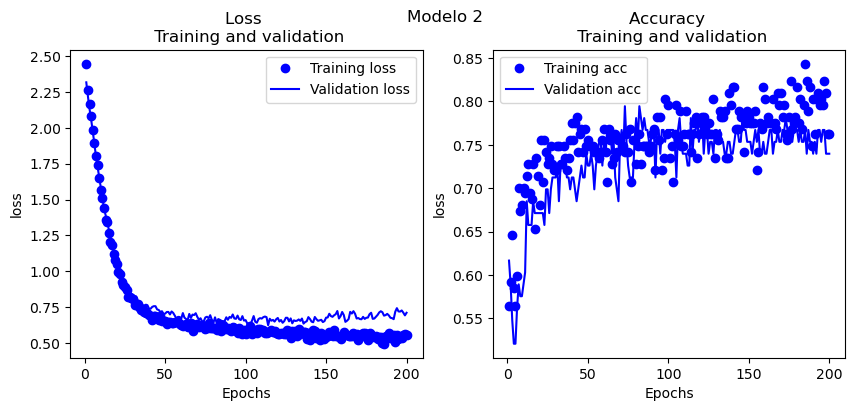

val_loss_min:  0.623  Epoch:  113


In [ ]:
#Graficando los valores de pérdida y accuracy para el entrenamiento y la validación
# Modelo 2

loss_values_2 = history_dict_2["loss"]
val_loss_values_2 = history_dict_2["val_loss"]
acc_2= history_dict_2["accuracy"]
val_acc_2 = history_dict_2["val_accuracy"]

epochs_2 = range(1, len(loss_values_2) + 1)
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(10,4))
fig.suptitle('Modelo 2')

ax1.plot(epochs_2, loss_values_2, "bo", label="Training loss")
ax1.plot(epochs_2, val_loss_values_2, "b", label="Validation loss")
ax1.set_title("Loss \n Training and validation")
ax1.set(xlabel="Epochs",ylabel='loss')

ax2.plot(epochs_2, acc_2, "bo", label="Training acc")
ax2.plot(epochs_2, val_acc_2, "b", label="Validation acc")
ax2.set_title("Accuracy \n Training and validation")
ax2.set(xlabel="Epochs",ylabel='loss')

ax1.legend()
ax2.legend()
plt.show()


print('val_loss_min: ',round(min(val_loss_values_2),3), ' Epoch: ',val_loss_values_2.index(min(val_loss_values_2)))

### Modelo 3

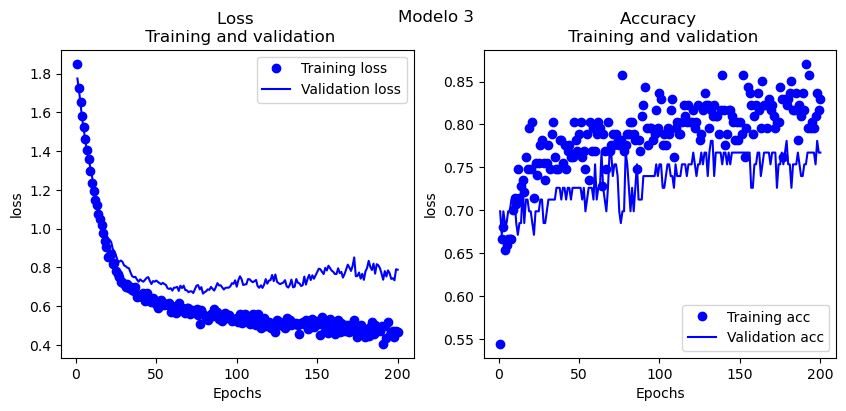

val_loss_min:  0.623  Epoch:  113


In [ ]:
#Graficando los valores de pérdida y accuracy para el entrenamiento y la validación
# Modelo 3

loss_values_3 = history_dict_3["loss"]
val_loss_values_3 = history_dict_3["val_loss"]
acc_3= history_dict_3["accuracy"]
val_acc_3 = history_dict_3["val_accuracy"]

epochs_3 = range(1, len(loss_values_3) + 1)
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(10,4))
fig.suptitle('Modelo 3')

ax1.plot(epochs_3, loss_values_3, "bo", label="Training loss")
ax1.plot(epochs_3, val_loss_values_3, "b", label="Validation loss")
ax1.set_title("Loss \n Training and validation")
ax1.set(xlabel="Epochs",ylabel='loss')

ax2.plot(epochs_3, acc_3, "bo", label="Training acc")
ax2.plot(epochs_3, val_acc_3, "b", label="Validation acc")
ax2.set_title("Accuracy \n Training and validation")
ax2.set(xlabel="Epochs",ylabel='loss')

ax1.legend()
ax2.legend()
plt.show()


print('val_loss_min: ',round(min(val_loss_values_2),3), ' Epoch: ',val_loss_values_2.index(min(val_loss_values_2)))

## Análisis

Como podemos ver los 3 modelos obtuvieron resultados similares a la hora de evaluar con los datos de prueba, obteniendo

Modelo 1: loss: 0.5570 - accuracy: 0.7975

Modelo 2: loss: 0.6472 - accuracy: 0.8228

Modelo 3: loss: 0.6472 - accuracy: 0.8228

Concluimos que a pesar de que las gráficas del modelo 1 no son tan buenas en el sentido en el que estamos acostumbrados a ver este tipo de gráficas (el modelo 2 y 3 en cambio si) cumple con que la función de pérdida llega a un mínimo en algún momento y después empieza a sobreajustar, y al ser el modelo más simple por que es el que tiene menos neuronas por capa densa y no hace uso de regularizadores o dropout el modelo 1 es el mejor.  

In [ ]:
etiquetas.sum()/len(etiquetas)

0.3210702341137124

Además vemos que el modelo es útil por que calculando la probabilidad simple de que tomando los datos al azar de uno de los pacientes se tiene una probabilidad del 32%  de que salga con paro cardiaco, mientras que con la red neuronal tenemos casi un 80%